<div class="alert alert-block alert-info">
This file shows how to call the Self-Organizing Map (SOM) code zSOM and executes an example run. For questions, bugs, and errors, please contact Derek Wilson (dnwilson@uci.edu).
</div>

In [1]:
#standard data analysis libraries
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

#for reading fits files
from astropy.io import fits

#additional analysis functions
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.signal import argrelextrema
from sklearn import decomposition


#import SOM class and auxiliary functions
import PhotSOM
import som_utils as su

<div class="alert alert-block alert-info">
Specify the locations of the training and control datasets.
</div>

In [2]:
training_data_dir = "./PhotSOM/PhotSOM/data/goodss_training_catalog.fits"
control_data_dir  = "./PhotSOM/PhotSOM/data/goodss_control_catalog.fits"

In [3]:
validation = False

<div class="alert alert-block alert-info">
Load the training data.
</div>

In [4]:
train_df = su.load_data(training_data_dir)
train_df = su.compute_color_columns(train_df)
print(list(train_df))

['zspec', 'VIMOS_U_FLUX', 'VIMOS_U_FLUX_ERR', 'ACS_F435W_FLUX', 'ACS_F435W_FLUX_ERR', 'ACS_F606W_FLUX', 'ACS_F606W_FLUX_ERR', 'ACS_F775W_FLUX', 'ACS_F775W_FLUX_ERR', 'ACS_F850LP_FLUX', 'ACS_F850LP_FLUX_ERR', 'WFC3_F098M_FLUX', 'WFC3_F098M_FLUX_ERR', 'WFC3_F105W_FLUX', 'WFC3_F105W_FLUX_ERR', 'WFC3_F125W_FLUX', 'WFC3_F125W_FLUX_ERR', 'WFC3_F160W_FLUX', 'WFC3_F160W_FLUX_ERR', 'ISAAC_KS_FLUX', 'ISAAC_KS_FLUX_ERR', 'IRAC_CH1_FLUX', 'IRAC_CH1_FLUX_ERR', 'IRAC_CH2_FLUX', 'IRAC_CH2_FLUX_ERR', 'IRAC_CH3_FLUX', 'IRAC_CH3_FLUX_ERR', 'IRAC_CH4_FLUX', 'IRAC_CH4_FLUX_ERR', 'RE_GALFIT_BAND', 'RE_GALFIT_BAND_ERR', 'RE_GALFIT_BAND_B', 'RE_GALFIT_BAND_B_ERR', 'RE_GALFIT_BAND_D', 'RE_GALFIT_BAND_D_ERR', 'R12_cir_H', 'C_H', 'A_H', 'S_H', 'G_H', 'R12_cir_J', 'C_J', 'A_J', 'S_J', 'G_J', '(VIMOS_U_FLUX/ACS_F435W_FLUX)', '(VIMOS_U_FLUX/ACS_F435W_FLUX)_ERR', '(ACS_F435W_FLUX/ACS_F606W_FLUX)', '(ACS_F435W_FLUX/ACS_F606W_FLUX)_ERR', '(ACS_F606W_FLUX/ACS_F775W_FLUX)', '(ACS_F606W_FLUX/ACS_F775W_FLUX)_ERR', '(ACS_

<div class="alert alert-block alert-info">
Add artificial error columns for rows that don't have errors, if desired.
</div>

In [5]:
train_df['zspec_ERR'] = np.ones(len(train_df['zspec']))
train_df = su.add_error_columns(train_df, error_fraction=0.1)

<div class="alert alert-block alert-info">
Compute colors from the fluxes. (This may generate a runtime warning. This is due to the NaNs in the data set.)
</div>

In [6]:
#train_df = su.compute_color_columns(train_df)

<div class="alert alert-block alert-info">
Make a redshift cut, if desired.
</div>

In [7]:
train_df = su.make_redshift_cut(train_df, cutoff=2.0)

<div class="alert alert-block alert-info">
Randomly reshuffle the rows.
</div>

In [8]:
#train_df = train_df.sample(frac=1).reset_index(drop=True)

In [9]:
if validation:
    cut = int(np.floor(0.7*colordf.shape[0]))
    colordf = colordf[0:cut]
    valdf = colordf[cut:]

<div class="alert alert-block alert-info">
Edit the data features that we want to use. The sample data contain photometric as well as morphological features.
</div>

In [10]:
train_df.drop(['C_H', 'C_H_ERR', 'A_H', 'A_H_ERR', 'S_H', 'S_H_ERR'], axis=1, inplace=True)
train_df.drop(['C_J', 'C_J_ERR', 'A_J', 'A_J_ERR', 'S_J', 'S_J_ERR', 'G_J', 'G_J_ERR', 'G_H', 'G_H_ERR'], axis=1, inplace=True)
train_df.drop(['R12_cir_H', 'R12_cir_H_ERR'], axis=1, inplace=True)
train_df.drop(['R12_cir_J', 'R12_cir_J_ERR'], axis=1, inplace=True)
train_df.drop(['RE_GALFIT_BAND_B', 'RE_GALFIT_BAND_B_ERR', 'RE_GALFIT_BAND_D', 'RE_GALFIT_BAND_D_ERR'], axis=1, inplace=True)
train_df.drop(['RE_GALFIT_BAND', 'RE_GALFIT_BAND_ERR'], axis=1, inplace=True)
train_df.drop(['VIMOS_U_FLUX', 'VIMOS_U_FLUX_ERR', 'ACS_F435W_FLUX', 'ACS_F435W_FLUX_ERR', 'ACS_F606W_FLUX', 'ACS_F606W_FLUX_ERR', 'ACS_F775W_FLUX', 'ACS_F775W_FLUX_ERR', 'ACS_F850LP_FLUX', 'ACS_F850LP_FLUX_ERR', 'WFC3_F098M_FLUX', 'WFC3_F098M_FLUX_ERR', 'WFC3_F105W_FLUX', 'WFC3_F105W_FLUX_ERR', 'WFC3_F125W_FLUX', 'WFC3_F125W_FLUX_ERR', 'WFC3_F160W_FLUX', 'WFC3_F160W_FLUX_ERR'], axis=1, inplace=True)
train_df.drop(['IRAC_CH1_FLUX', 'IRAC_CH1_FLUX_ERR', 'IRAC_CH2_FLUX', 'IRAC_CH2_FLUX_ERR', 'IRAC_CH3_FLUX', 'IRAC_CH3_FLUX_ERR', 'IRAC_CH4_FLUX', 'IRAC_CH4_FLUX_ERR'], axis=1, inplace=True)

In [11]:
print(list(train_df))
print(len(list(train_df)))
print(train_df.head())

['zspec', 'ISAAC_KS_FLUX', 'ISAAC_KS_FLUX_ERR', '(VIMOS_U_FLUX/ACS_F435W_FLUX)', '(VIMOS_U_FLUX/ACS_F435W_FLUX)_ERR', '(ACS_F435W_FLUX/ACS_F606W_FLUX)', '(ACS_F435W_FLUX/ACS_F606W_FLUX)_ERR', '(ACS_F606W_FLUX/ACS_F775W_FLUX)', '(ACS_F606W_FLUX/ACS_F775W_FLUX)_ERR', '(ACS_F775W_FLUX/ACS_F850LP_FLUX)', '(ACS_F775W_FLUX/ACS_F850LP_FLUX)_ERR', '(ACS_F850LP_FLUX/WFC3_F098M_FLUX)', '(ACS_F850LP_FLUX/WFC3_F098M_FLUX)_ERR', '(WFC3_F098M_FLUX/WFC3_F105W_FLUX)', '(WFC3_F098M_FLUX/WFC3_F105W_FLUX)_ERR', '(WFC3_F105W_FLUX/WFC3_F125W_FLUX)', '(WFC3_F105W_FLUX/WFC3_F125W_FLUX)_ERR', '(WFC3_F125W_FLUX/WFC3_F160W_FLUX)', '(WFC3_F125W_FLUX/WFC3_F160W_FLUX)_ERR', '(WFC3_F160W_FLUX/ISAAC_KS_FLUX)', '(WFC3_F160W_FLUX/ISAAC_KS_FLUX)_ERR', '(ISAAC_KS_FLUX/IRAC_CH1_FLUX)', '(ISAAC_KS_FLUX/IRAC_CH1_FLUX)_ERR', '(IRAC_CH1_FLUX/IRAC_CH2_FLUX)', '(IRAC_CH1_FLUX/IRAC_CH2_FLUX)_ERR', '(IRAC_CH2_FLUX/IRAC_CH3_FLUX)', '(IRAC_CH2_FLUX/IRAC_CH3_FLUX)_ERR', '(IRAC_CH3_FLUX/IRAC_CH4_FLUX)', '(IRAC_CH3_FLUX/IRAC_CH4_FLUX

In [12]:
train_df = su.reorder_column(train_df, 1, 'zspec_ERR')

print(list(train_df))
print(len(list(train_df)))

#train_df.to_csv('TRAINING_DF_WITH_Z.csv', index=False)


train = train_df.copy()
train.drop(['zspec_ERR'], axis=1, inplace=True)
train = su.reorder_column(train, -1, 'zspec')
train[np.isnan(train)] = 0.
#train.to_csv('TRAIN_DF_PHOTORAPTOR.csv', index=False)

['zspec', 'zspec_ERR', 'ISAAC_KS_FLUX', 'ISAAC_KS_FLUX_ERR', '(VIMOS_U_FLUX/ACS_F435W_FLUX)', '(VIMOS_U_FLUX/ACS_F435W_FLUX)_ERR', '(ACS_F435W_FLUX/ACS_F606W_FLUX)', '(ACS_F435W_FLUX/ACS_F606W_FLUX)_ERR', '(ACS_F606W_FLUX/ACS_F775W_FLUX)', '(ACS_F606W_FLUX/ACS_F775W_FLUX)_ERR', '(ACS_F775W_FLUX/ACS_F850LP_FLUX)', '(ACS_F775W_FLUX/ACS_F850LP_FLUX)_ERR', '(ACS_F850LP_FLUX/WFC3_F098M_FLUX)', '(ACS_F850LP_FLUX/WFC3_F098M_FLUX)_ERR', '(WFC3_F098M_FLUX/WFC3_F105W_FLUX)', '(WFC3_F098M_FLUX/WFC3_F105W_FLUX)_ERR', '(WFC3_F105W_FLUX/WFC3_F125W_FLUX)', '(WFC3_F105W_FLUX/WFC3_F125W_FLUX)_ERR', '(WFC3_F125W_FLUX/WFC3_F160W_FLUX)', '(WFC3_F125W_FLUX/WFC3_F160W_FLUX)_ERR', '(WFC3_F160W_FLUX/ISAAC_KS_FLUX)', '(WFC3_F160W_FLUX/ISAAC_KS_FLUX)_ERR', '(ISAAC_KS_FLUX/IRAC_CH1_FLUX)', '(ISAAC_KS_FLUX/IRAC_CH1_FLUX)_ERR', '(IRAC_CH1_FLUX/IRAC_CH2_FLUX)', '(IRAC_CH1_FLUX/IRAC_CH2_FLUX)_ERR', '(IRAC_CH2_FLUX/IRAC_CH3_FLUX)', '(IRAC_CH2_FLUX/IRAC_CH3_FLUX)_ERR', '(IRAC_CH3_FLUX/IRAC_CH4_FLUX)', '(IRAC_CH3_FLUX/

<div class="alert alert-block alert-info">
Set number of SOM weights to be the number of data features. The input dataframe also contains the uncertainties in the features, so we must divide the size of the dataframe by 2.
</div>

In [13]:
num_weights = int(train_df.shape[1] / 2.)
weight_labels = list(train_df)

<div class="alert alert-block alert-info">
Initialize the SOM.
</div>

In [14]:
som = PhotSOM.SOM([150, 150])
som.initialize_weights(num_weights, weight_labels)

<div class="alert alert-block alert-info">
Train the SOM.
</div>

In [15]:
som.train(30, train_df)

0 %
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
100.0%


<div class="alert alert-block alert-info">
Save the SOM.
</div>

In [16]:
#som.save_map('som_weights')

<div class="alert alert-block alert-info">
Load the test data and do some preprocessing.
</div>

In [17]:
test_df = su.load_data(control_data_dir)
test_df = su.make_redshift_cut(test_df, cutoff=2.0)
h_band = test_df['WFC3_F160W_FLUX'].values
test_df = su.add_error_columns(test_df, error_fraction=0.1)
test_df = su.compute_color_columns(test_df)
test_df = test_df.sample(frac=1).reset_index(drop=True)

<div class="alert alert-block alert-info">
Drop unwanted data features as we did for the training set.
</div>

In [18]:
test_df.drop(['C_H', 'C_H_ERR', 'A_H', 'A_H_ERR', 'S_H', 'S_H_ERR'], axis=1, inplace=True)
test_df.drop(['C_J', 'C_J_ERR', 'A_J', 'A_J_ERR', 'S_J', 'S_J_ERR', 'G_J', 'G_J_ERR', 'G_H', 'G_H_ERR'], axis=1, inplace=True)
test_df.drop(['R12_cir_H', 'R12_cir_H_ERR'], axis=1, inplace=True)
test_df.drop(['R12_cir_J', 'R12_cir_J_ERR'], axis=1, inplace=True)
test_df.drop(['RE_GALFIT_BAND_B', 'RE_GALFIT_BAND_B_ERR', 'RE_GALFIT_BAND_D', 'RE_GALFIT_BAND_D_ERR'], axis=1, inplace=True)
test_df.drop(['RE_GALFIT_BAND', 'RE_GALFIT_BAND_ERR'], axis=1, inplace=True)
test_df.drop(['VIMOS_U_FLUX', 'VIMOS_U_FLUX_ERR', 'ACS_F435W_FLUX', 'ACS_F435W_FLUX_ERR', 'ACS_F606W_FLUX', 'ACS_F606W_FLUX_ERR', 'ACS_F775W_FLUX', 'ACS_F775W_FLUX_ERR', 'ACS_F850LP_FLUX', 'ACS_F850LP_FLUX_ERR', 'WFC3_F098M_FLUX', 'WFC3_F098M_FLUX_ERR', 'WFC3_F105W_FLUX', 'WFC3_F105W_FLUX_ERR', 'WFC3_F125W_FLUX', 'WFC3_F125W_FLUX_ERR', 'WFC3_F160W_FLUX', 'WFC3_F160W_FLUX_ERR'], axis=1, inplace=True)
test_df.drop(['IRAC_CH1_FLUX', 'IRAC_CH1_FLUX_ERR', 'IRAC_CH2_FLUX', 'IRAC_CH2_FLUX_ERR', 'IRAC_CH3_FLUX', 'IRAC_CH3_FLUX_ERR', 'IRAC_CH4_FLUX', 'IRAC_CH4_FLUX_ERR'], axis=1, inplace=True)

In [19]:
print(test_df.head())

    zspec  ISAAC_KS_FLUX  ISAAC_KS_FLUX_ERR  zspec_ERR  \
0  0.5323        2.56769           0.164159    0.05323   
1  1.0870        3.12578           0.085801    0.10870   
2  1.0446            NaN                NaN    0.10446   
3  0.4240        8.77303           0.131665    0.04240   
4  1.7625        1.25045           0.094142    0.17625   

   (VIMOS_U_FLUX/ACS_F435W_FLUX)  (VIMOS_U_FLUX/ACS_F435W_FLUX)_ERR  \
0                       0.292576                           0.073002   
1                       0.097766                           0.065020   
2                       0.349934                           0.058706   
3                       0.254204                           0.027979   
4                       0.091215                           0.058258   

   (ACS_F435W_FLUX/ACS_F606W_FLUX)  (ACS_F435W_FLUX/ACS_F606W_FLUX)_ERR  \
0                         0.898719                             0.071396   
1                         0.328845                             0.068650   

In [20]:
test_df = su.reorder_column(test_df, 1, 'zspec_ERR')
#test_df.to_csv('TESTING_DF_WITH_Z.csv', index=False)



tes = test_df.copy()
tes = su.reorder_column(tes, -1, 'zspec')
tes[np.isnan(tes)] = 0.
#tes.to_csv('TESTING_DF_WITH_Z_PHOTORAPTOR.csv', index=False)

In [21]:
test_zspec = test_df['zspec'].values.copy()
test_df['zspec']     = np.nan
test_df['zspec_ERR'] = np.nan

In [22]:
testing = test_df.copy()
testing.drop(['zspec', 'zspec_ERR'], axis=1, inplace=True)
#testing.to_csv('TESTING_DF_NO_Z.csv', index=False)


testing[np.isnan(testing)] = 0.
#testing.to_csv('TESTING_DF_NO_Z_PHOTORAPTOR.csv', index=False)

<div class="alert alert-block alert-info">
Have the SOM predict redshift for the test data.
</div>

In [23]:
bmuzs = som.test(test_df)

0 %
5.0%
10.0%
15.0%
20.0%
25.0%
30.0%
35.0%
40.0%
45.0%
50.0%
55.0%
60.0%
65.0%
70.0%
75.0%
80.0%
85.0%
90.0%
95.0%


<div class="alert alert-block alert-info">
Option to save the predicted redshifts along with the spectroscopic redshifts.
</div>

In [24]:
h_band = -2.5*np.log10(h_band/(3.631*10**9))


savedf = pd.DataFrame()
savedf['photz'] = bmuzs
savedf['specz'] = test_zspec
savedf['hband'] = h_band
#savedf.to_csv('output_no_size.csv', index=False)

<div class="alert alert-block alert-info">
Plot up the results to see how well the SOM did.
</div>

<IPython.core.display.Javascript object>


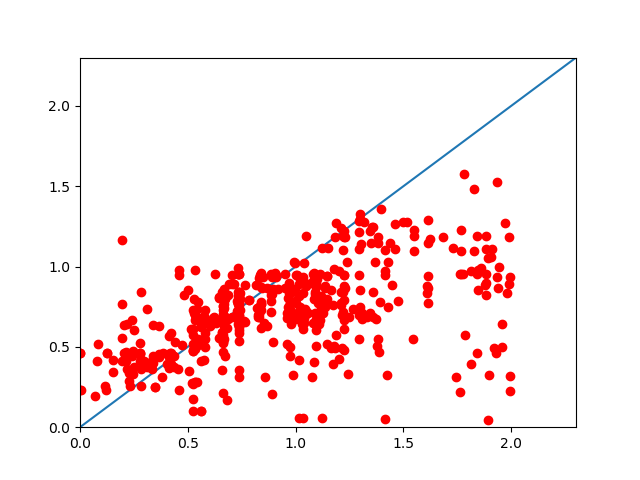

(0, 2.3)

In [25]:
xupper = 2.3
yupper = 2.3
plt.figure()
plt.plot([0,xupper],[0,yupper])
plt.plot(test_zspec, bmuzs, 'ro')
plt.xlim([0,xupper])
plt.ylim([0,yupper])

<div class="alert alert-block alert-info">
Lastly, we want to see quantitatively how we did. We'll do this by computing $\Delta$z/(1 + z$_{spec}$), which is a normalized difference between the predicted and spectroscopic redshifts, and dropping the outliers ($\Delta$z/(1 + z$_{spec}$) > 0.15). We then compute $\sigma$, the root-mean-square deviation between predicted and spectroscopic redshifts for the entire test sample. Ideally, we would like $\sigma$ and the outlier fraction (percentage of the sample that we had to drop) to be as low as possible. 
</div>

In [26]:
keep = np.where(np.abs((test_zspec - bmuzs) / (1 + test_zspec)) <= 0.15)
bm = bmuzs[keep]
zs = test_zspec[keep]

In [27]:
print('sigma_full')
print(su.rms((test_zspec - bmuzs) / (1 + test_zspec)))

print('sigma_outliers')
print(su.rms((zs - bm) / (1 + zs)))

print('outlier fraction')
print(1 - len(bm)/len(bmuzs))

sigma_full
0.19811668012354064
sigma_outliers
0.07438167770074497
outlier fraction
0.3972332015810277


<div class="alert alert-block alert-info">
Begin pdf calculation with resampled data and subsets of data
</div>

In [28]:
#Nmaps = 500
#all_bmuzs = []
#all_bmuzs_df = pd.DataFrame()
#for n in range(Nmaps):
#    print('Iteration: ' + str(n))
#    resampled_train_df = su.resample_data(train_df, seed=n)
#    subset_train_df   = su.subset_data(resampled_train_df, seed=n)
#    subset_test_df   = su.subset_data(test_df, seed=n)
#    num_weights = int(subset_train_df.shape[1] / 2.)
#    weight_labels = list(subset_train_df)
#    newmap = PhotSOM.SOM([150, 150])
#    newmap.initialize_weights(num_weights, weight_labels, rseed=n)
#    newmap.train(3000, subset_train_df, verbose=False, seed=n)
#    #newmap.save_map('/home/dnwilson/SelfOrganizingMaps/som_probability_storage/som_weights_resamp_subset_' + str(n))
#    bmuzs = newmap.test(subset_test_df, verbose=False)
#    all_bmuzs.append(bmuzs)
#    all_bmuzs_df['bmuzs'+str(n)] = np.array(bmuzs)

In [29]:
Nmaps = 500
all_bmuzs = []
all_bmuzs_df = pd.DataFrame()
for n in range(Nmaps):
    print('Iteration: ' + str(n))
    newmap = PhotSOM.loadSOM('/home/dnwilson/SelfOrganizingMaps/som_probability_storage/som_weights_resamp_' + str(n))
    #subset_test_df   = su.subset_data(test_df, seed=n)
    bmuzs = newmap.test(test_df, verbose=False)
    all_bmuzs.append(bmuzs)
    all_bmuzs_df['bmuzs'+str(n)] = np.array(bmuzs)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
It

In [30]:
#all_bmuzs_df.to_csv('all_bmu_zphot.csv', index=False)

<div class="alert alert-block alert-info">
Begin pdf calculation with only resampled data
</div>

In [31]:
#Nmaps = 500
#all_bmuzs = []
#all_bmuzs_df = pd.DataFrame()
#for n in range(Nmaps):
#    print('Iteration: ' + str(n))
#    resampled_train_df = su.resample_data(train_df, seed=n)
#    num_weights = int(resampled_train_df.shape[1] / 2.)
#    weight_labels = list(resampled_train_df)
#    newmap = PhotSOM.SOM([150, 150])
#    newmap.initialize_weights(num_weights, weight_labels, rseed=n)
#    newmap.train(3000, resampled_train_df, verbose=False, seed=n)
#    newmap.save_map('/home/dnwilson/SelfOrganizingMaps/som_probability_storage/som_weights_resamp_withR' + str(n))
#    bmuzs = newmap.test(test_df, verbose=False)
#    all_bmuzs.append(bmuzs)
#    all_bmuzs_df['bmuzs'+str(n)] = np.array(bmuzs)

In [32]:
#all_bmuzs_df.to_csv('all_bmu_zphot_resamp_withR.csv', index=False)

In [33]:
#Nmaps = 500
#all_bmuzs = []
#all_bmuzs_df = pd.DataFrame()
#for n in range(Nmaps):
#    print('Iteration: ' + str(n))
#    newmap = PhotSOM.loadSOM('/home/dnwilson/SelfOrganizingMaps/som_probability_storage/som_weights_resamp_withR' + str(n))
#    subset_test_df   = su.subset_data(test_df, seed=n)
#    bmuzs = newmap.test(subset_test_df, verbose=False)
#    all_bmuzs.append(bmuzs)
#    all_bmuzs_df['bmuzs'+str(n)] = np.array(bmuzs)

In [34]:
#all_bmuzs_df.to_csv('all_bmu_zphot_resamp.csv', index=False)

In [35]:
#print(len(test_zspec))
#all_means = []
#all_medians = []
#all_errors = []
#for m in range(len(test_zspec)):
#    print('Iteration: ' + str(m))
#    pdf = []
#    for nn in range(Nmaps):
#        pdf.append(all_bmuzs[nn][m])
#    all_means.append(np.mean(pdf))
#    all_medians.append(np.median(pdf))
#    all_errors.append(np.std(pdf))

In [36]:
#photoz_df = pd.DataFrame()
#photoz_df['specz'] = test_zspec
#photoz_df['means'] = all_means
#photoz_df['medians'] = all_medians
#photoz_df['stdvs'] = all_errors
#photoz_df.to_csv('output/photoz_dataframe_resamp_withR.csv', index=False)

<div class="alert alert-block alert-info">
Begin pdf calculation with only subsets of data
</div>

In [37]:
#Nmaps = 500
#all_bmuzs = []
#all_bmuzs_df = pd.DataFrame()
#for n in range(Nmaps):
#    print('Iteration: ' + str(n))
#    subset_train_df   = su.subset_data(train_df, seed=n)
#    subset_test_df   = su.subset_data(test_df, seed=n)
#    num_weights = int(subset_train_df.shape[1] / 2.)
#    weight_labels = list(subset_train_df)
#    newmap = PhotSOM.SOM([150, 150])
#    newmap.initialize_weights(num_weights, weight_labels, rseed=n)
#    newmap.train(3000, subset_train_df, verbose=False, seed=n)
#    #newmap.save_map('/home/dnwilson/SelfOrganizingMaps/som_probability_storage/som_weights_subset_' + str(n))
#    bmuzs = newmap.test(subset_test_df, verbose=False)
#    all_bmuzs.append(bmuzs)
#    all_bmuzs_df['bmuzs'+str(n)] = np.array(bmuzs)

#all_bmuzs_df.to_csv('all_bmu_zphot_subset.csv', index=False)

In [38]:
#print(len(test_zspec))
#all_means = []
#all_medians = []
#all_errors = []
#for m in range(len(test_zspec)):
#    print('Iteration: ' + str(m))
#    pdf = []
#    for nn in range(Nmaps):
#        pdf.append(all_bmuzs[nn][m])
#    all_means.append(np.mean(pdf))
#    all_medians.append(np.median(pdf))
#    all_errors.append(np.std(pdf))

In [39]:
#photoz_df = pd.DataFrame()
#photoz_df['specz'] = test_zspec
#photoz_df['means'] = all_means
#photoz_df['medians'] = all_medians
#photoz_df['stdvs'] = all_errors
#photoz_df.to_csv('output/photoz_dataframe.csv', index=False)

In [40]:
#plt.figure()
#plt.plot(test_zspec, all_means, 'bo')

In [41]:
#plt.figure()
#plt.plot(test_zspec, all_medians, 'go')

In [54]:
num = 385

pdf = []
for nn in range(Nmaps):
    pdf.append(all_bmuzs[nn][num])
    
from scipy import stats
print('Spec z: ' + str(test_zspec[num]))
print('Photo z Mean: ' + str(np.mean(pdf)))
print('Photo z Median: ' + str(np.median(pdf)))
print('Photo z Mode: ' + str(stats.mode(pdf)))
print('Error estimate: ' + str(np.std(pdf)))

pdf_df = pd.DataFrame()
pdf_df['predictions'] = pdf
pdf_df.to_csv('output/predictions' + str(num) + '.csv', index=False)

Spec z: 0.278
Photo z Mean: 0.29860847443038163
Photo z Median: 0.2784877953420134
Photo z Mode: ModeResult(mode=array([0.19660395]), count=array([1]))
Error estimate: 0.08249351378428432


In [55]:
print(np.where(test_zspec == 0.278))

(array([ 21, 385]),)


<IPython.core.display.Javascript object>


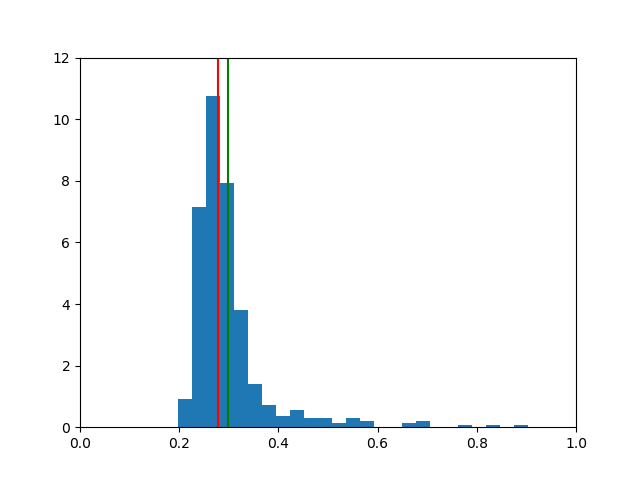

1.0000000000000004
(array([ 0.91923811,  7.14177301, 10.74801482,  7.91958987,  3.81837369,
        1.41421248,  0.70710624,  0.35355312,  0.56568499,  0.2828425 ,
        0.2828425 ,  0.14142125,  0.2828425 ,  0.21213187,  0.        ,
        0.        ,  0.14142125,  0.21213187,  0.        ,  0.        ,
        0.07071062,  0.        ,  0.07071062,  0.        ,  0.07071062]), array([0.19660395, 0.22488824, 0.25317254, 0.28145683, 0.30974112,
       0.33802542, 0.36630971, 0.394594  , 0.42287829, 0.45116259,
       0.47944688, 0.50773117, 0.53601547, 0.56429976, 0.59258405,
       0.62086834, 0.64915264, 0.67743693, 0.70572122, 0.73400552,
       0.76228981, 0.7905741 , 0.8188584 , 0.84714269, 0.87542698,
       0.90371127]), <a list of 25 Patch objects>)
0.986


In [67]:
plt.figure()

output = plt.hist(pdf, bins=25, density=True)
plt.plot([np.median(pdf), np.median(pdf)], [0, 150], 'r')
plt.plot([np.mean(pdf), np.mean(pdf)], [0, 150], 'g')
plt.xlim([0, 1])
plt.ylim([0, 12])

print((np.max(pdf) - np.min(pdf))/25.*np.sum(output[0]))
print(output)

print(np.trapz(output[0], output[1][1:]))

In [44]:
print(output[0])
print(len(output[0]))
print(output[1])
print(len(output[1]))


hist_nums_df = pd.DataFrame()
hist_nums_df['hist_nums'] = np.array(output[0])
hist_nums_df.to_csv('output/hist_nums.csv', index=False)

hist_bin_edges_df = pd.DataFrame()
hist_bin_edges_df['hist_bin_edges'] = np.array(output[1])
hist_bin_edges_df.to_csv('output/hist_bin_edges.csv', index=False)

[ 1.  4.  0.  5. 12. 23. 25. 23. 24. 36. 42. 40. 38. 29. 32. 23. 25. 33.
 30. 27. 17.  8.  2.  0.  1.]
25
[0.75653318 0.76653122 0.77652925 0.78652729 0.79652532 0.80652336
 0.81652139 0.82651943 0.83651746 0.8465155  0.85651353 0.86651157
 0.8765096  0.88650763 0.89650567 0.9065037  0.91650174 0.92649977
 0.93649781 0.94649584 0.95649388 0.96649191 0.97648995 0.98648798
 0.99648602 1.00648405]
26
